In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import fft
from scipy import stats
from scipy.signal import get_window
import time

def filtering_func(freqs, fft, phases, f1, f2):  #passing complex numbers
    n = max(np.abs(fft))
    noise_fft = fft.copy()

    abs_fft = np.abs(fft)
    valid_indices = np.where((freqs >= f1) & (freqs <= f2) | (freqs >= -f2) & (freqs <= -f1))[0]

    fft_in_range = abs_fft[valid_indices]
    print(f'fft_in_range: {fft_in_range/n} ')

    peak = np.max(fft_in_range)

    local_peak_indices = np.where(abs_fft[valid_indices] == peak)[0]
    general_peak_indices = valid_indices[local_peak_indices]
    print(f"general_peak_indices: {general_peak_indices}")
    print(f"abs_fft[general_peak_indices]: {abs_fft[general_peak_indices]/n}")

    peak_f = freqs[general_peak_indices]
    print(f"peak_f: {peak_f}")

    peak_phase = phases[general_peak_indices]
    print(f"peak_phase: {peak_phase}")

    print(f'sum: {np.sum(np.isin(freqs, peak_f))}')
    mask = np.ones(len(noise_fft), dtype=bool)
    mask[general_peak_indices] = False
    noise_fft[mask] = complex(0, 0)
    return noise_fft, peak_f, peak_phase

In [2]:
hour = '15.42'
day = '08082024'

In [3]:
file = f"../../Waveforms/{day}/{day}_{hour}/{day}_{hour}_wf.csv/{day}_{hour}_wf_01.csv"

df = pd.read_csv(file)
times = pd.to_numeric(df.iloc[1:, 0], errors = 'coerce').values
amplitudes = pd.to_numeric(df.iloc[1:, 1], errors='coerce').values
        
N = len(times)
print(f"len(times): {N}")

len(times): 62504


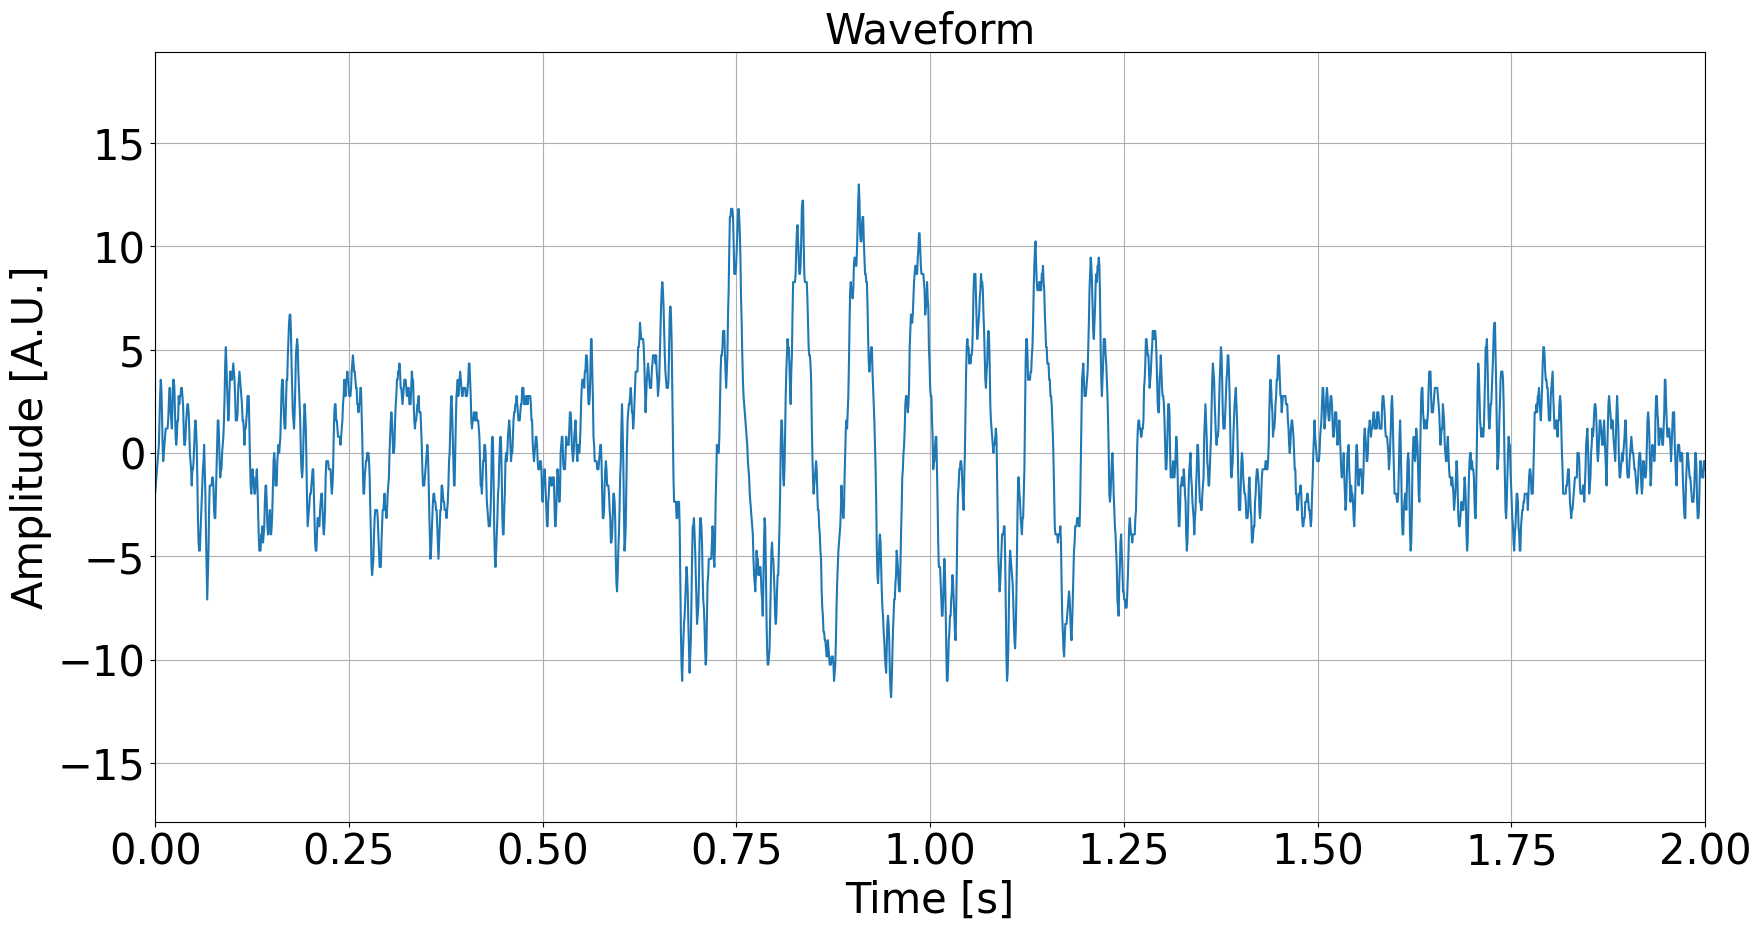

In [4]:
plt.figure(figsize = (20, 10))
plt.plot(times, amplitudes, label = 'amplitudes')
plt.title('Waveform', fontsize = 30)
plt.xlabel('Time [s]', fontsize = 30)
plt.xticks(fontsize = 30)
plt.ylabel('Amplitude [A.U.]', fontsize = 30)
plt.yticks(fontsize = 30)
plt.xlim(0, 2)
plt.grid(True)

#plt.savefig("Results/simple_ifft.png", format = "png", bbox_inches="tight")
#plt.savefig("Results/simple_ifft.pdf", format = "pdf", bbox_inches="tight")
plt.show()

## FFT

In [5]:
span = times[-1]
print(f"span: {span}") 
f_s = len(times) / span
print(f"f_s = {f_s}")
freqs = fft.fftfreq(len(times), 1/f_s) #window lenght, sample spacing
print(f'last freq: {freqs[-1]}') ##this should be the half of f_s.
print(f"len(freqs): {len(freqs)}")
print(freqs)

span: 50.00240067
f_s = 1250.0199822905822
last freq: -0.019999039778103515
len(freqs): 62504
[ 0.          0.01999904  0.03999808 ... -0.05999712 -0.03999808
 -0.01999904]


In [6]:
magnitudes = fft.fft(amplitudes) #when i'm filtering, i'm filtering something complex
n = np.max(np.abs(magnitudes))

phases = np.angle(magnitudes)

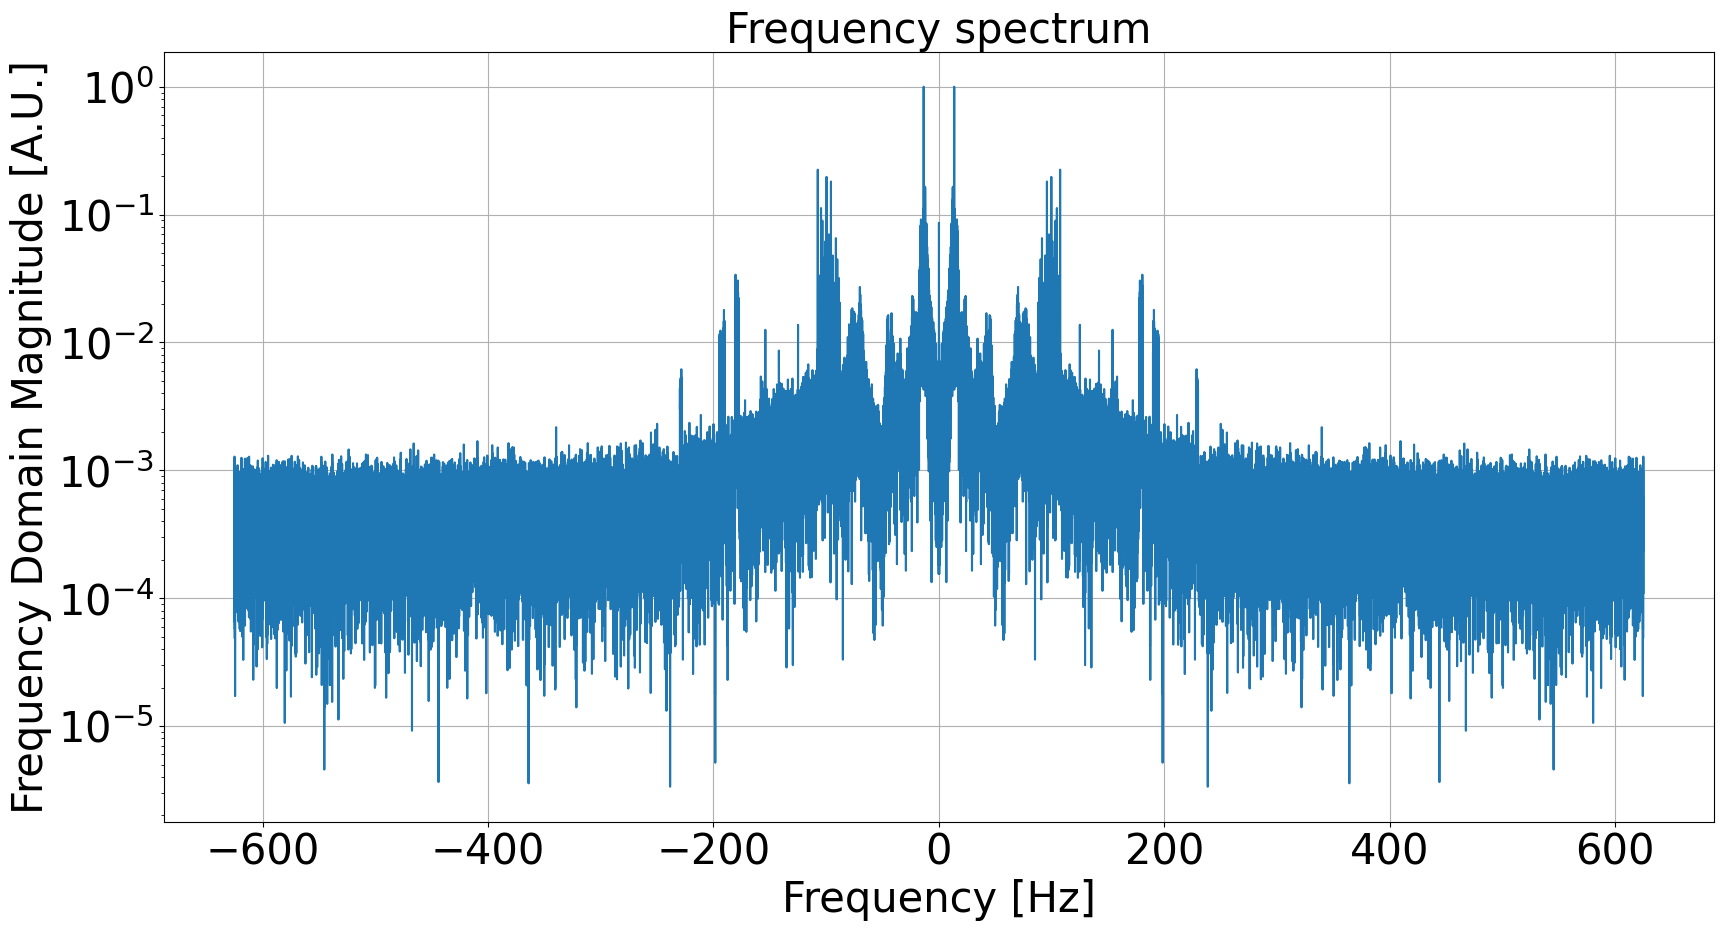

In [7]:
freqs_shifted = fft.fftshift(freqs)
magnitudes_shifted = fft.fftshift(magnitudes)

plt.figure(figsize=(20, 10))
plt.plot(freqs_shifted, np.abs(magnitudes_shifted)/n)
plt.title('Frequency spectrum', fontsize = 30)
plt.xlabel('Frequency [Hz]', fontsize = 30)
plt.xticks(fontsize = 30)
plt.ylabel('Frequency Domain Magnitude [A.U.]', fontsize = 30)
plt.yticks(fontsize = 30)
plt.semilogy()
plt.grid(True)

#plt.savefig("Results/simple_fft.png", format = "png", bbox_inches="tight")
#plt.savefig("Results/simple_fft.pdf", format = "pdf", bbox_inches="tight")
plt.show()

In [8]:
if (N%2 == 0):
    pos_freqs = freqs[:round((N/2))]
    pos_magnitudes = magnitudes[:round((N/2))]
    pos_phases = phases[:round((N/2))]
    pos_amplitudes = amplitudes[:round((N/2))]
else:
    pos_freqs = freqs[:round((N-1)/2 + 1)]
    pos_magnitudes = magnitudes[:round((N-1)/2 + 1)]
    pos_phases = phases[:round((N-1)/2 + 1)]
    pos_amplitudes = amplitudes[:round((N-1)/2 + 1)]

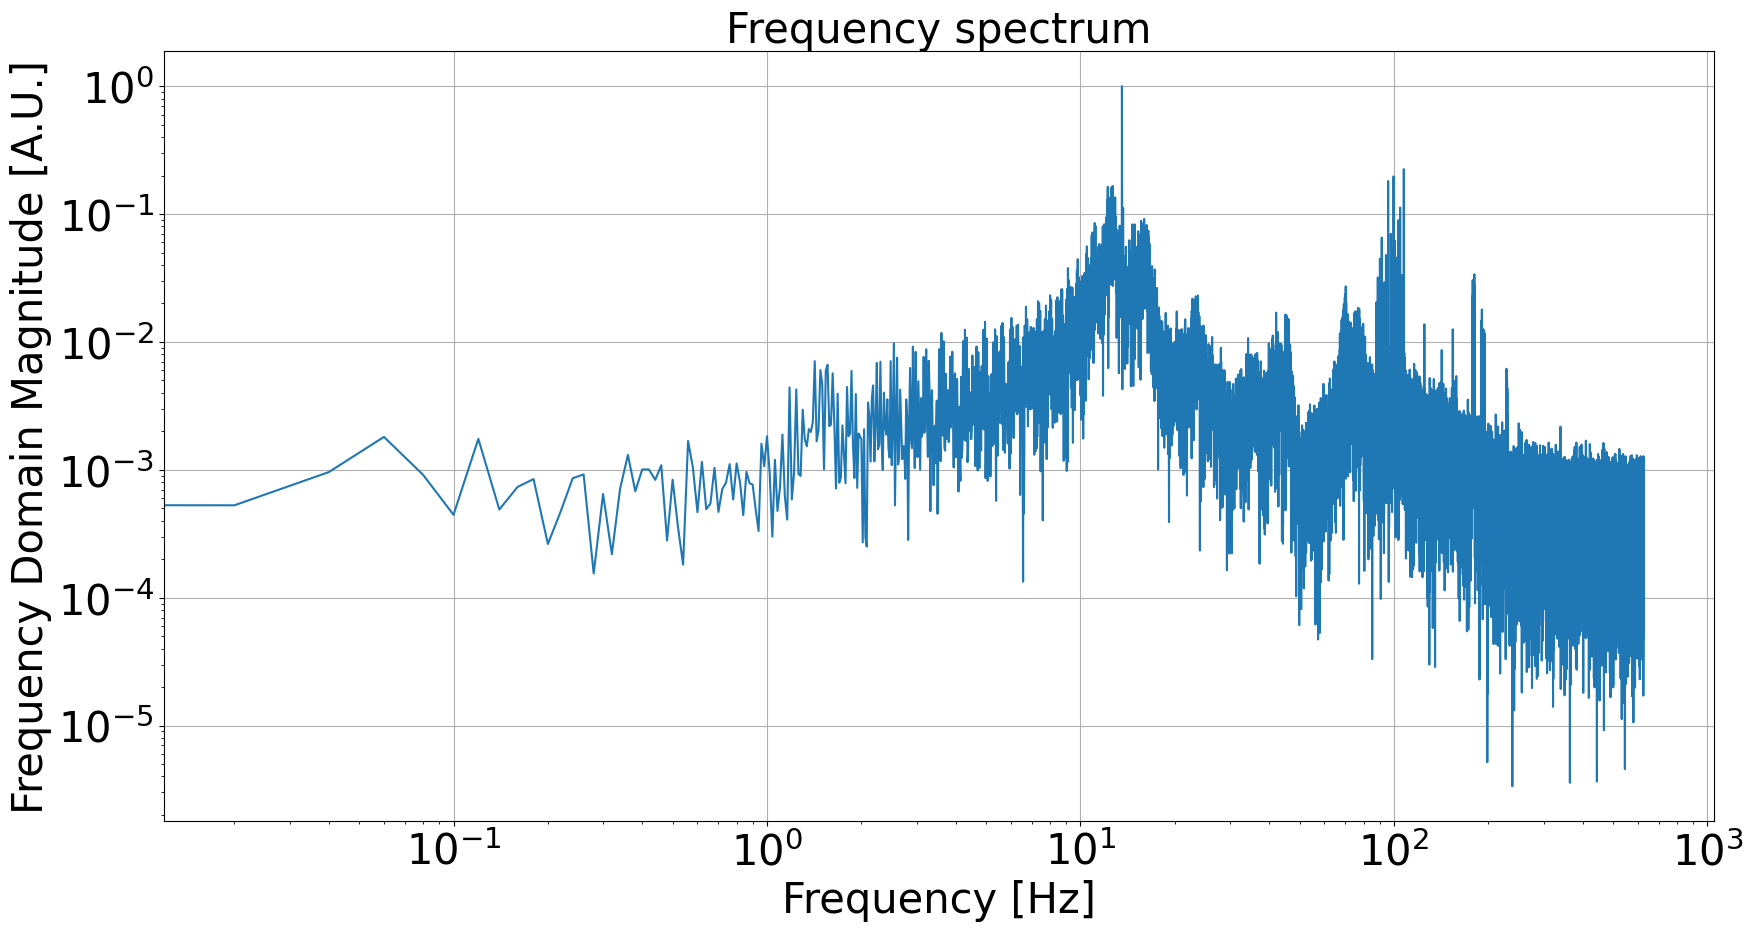

In [9]:
plt.figure(figsize=(20, 10))
plt.plot(pos_freqs, np.abs(pos_magnitudes)/n)

plt.title('Frequency spectrum', fontsize = 30)
plt.xlabel('Frequency [Hz]', fontsize = 30)
plt.xticks(fontsize = 30)
plt.ylabel('Frequency Domain Magnitude [A.U.]', fontsize = 30)
plt.yticks(fontsize = 30)
plt.loglog()
plt.grid(True)

#plt.savefig("Results/simple_fft.png", format = "png", bbox_inches="tight")
#plt.savefig("Results/simple_fft.pdf", format = "pdf", bbox_inches="tight")
plt.show()

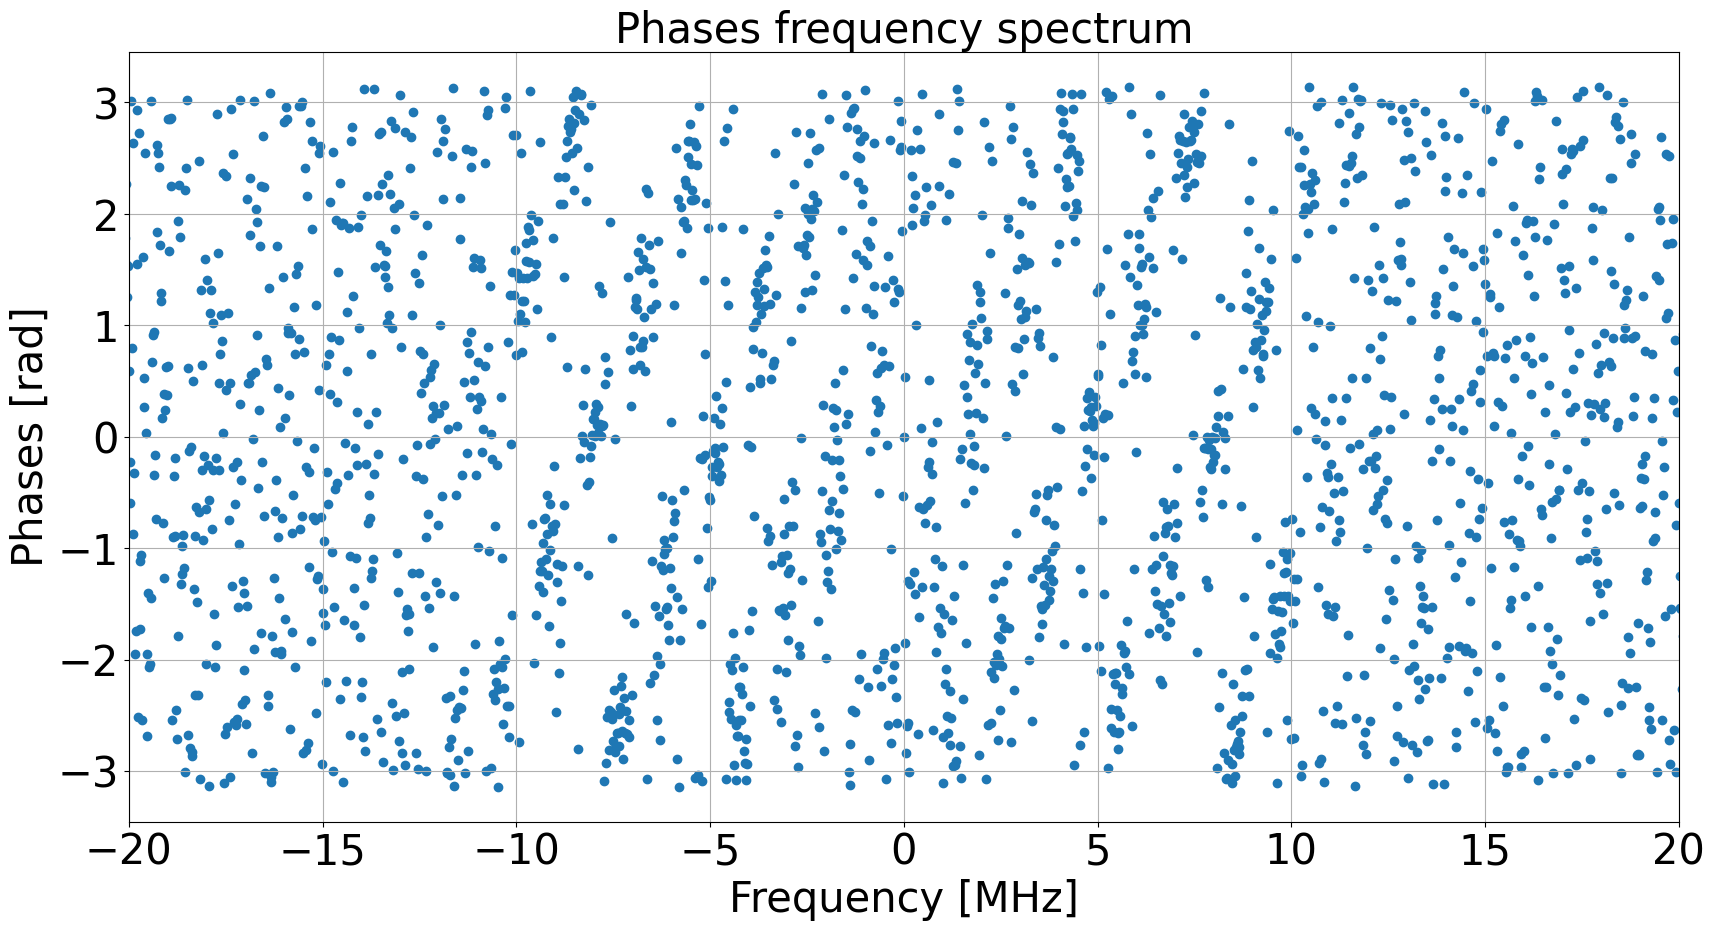

In [10]:
plt.figure(figsize=(20, 10))
plt.scatter(freqs, phases)

plt.title('Phases frequency spectrum', fontsize = 30)
plt.xlabel('Frequency [MHz]', fontsize = 30)
plt.xticks(fontsize = 30)
plt.ylabel('Phases [rad]', fontsize = 30)
plt.yticks(fontsize = 30)
plt.grid(True)
plt.xlim(-20, 20)

#plt.savefig("250724_17.23/fft.pdf", format = "pdf", bbox_inches="tight")
plt.show()

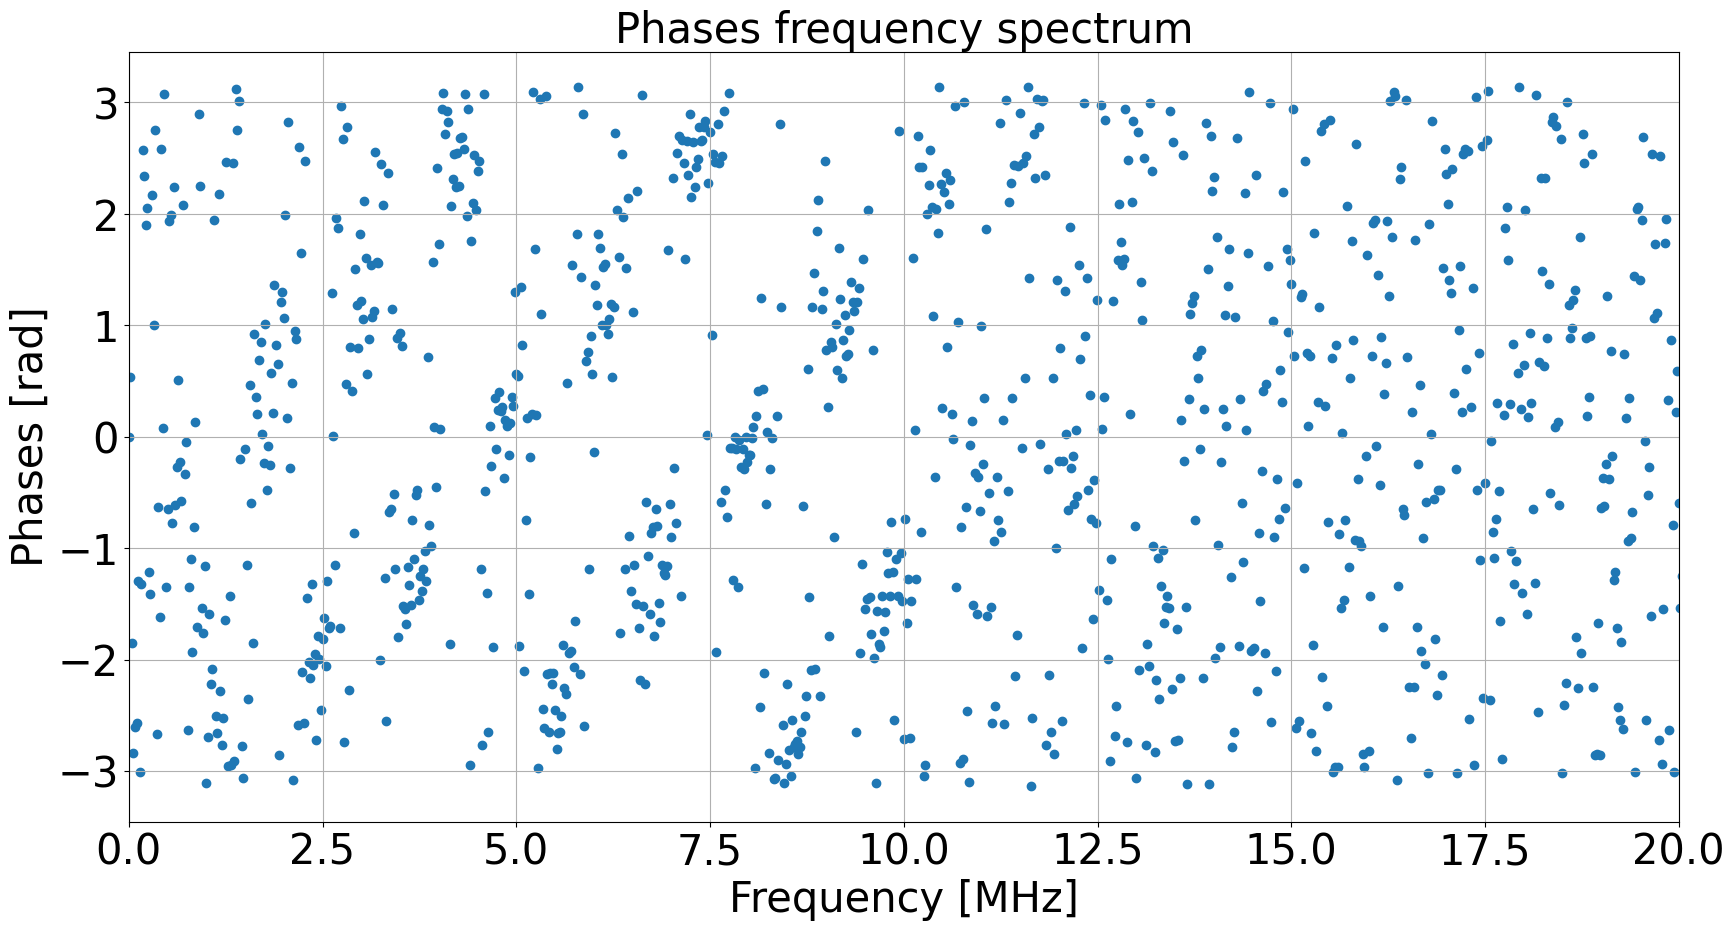

In [11]:
plt.figure(figsize=(20, 10))
plt.scatter(pos_freqs, pos_phases)

plt.title('Phases frequency spectrum', fontsize = 30)
plt.xlabel('Frequency [MHz]', fontsize = 30)
plt.xticks(fontsize = 30)
plt.ylabel('Phases [rad]', fontsize = 30)
plt.yticks(fontsize = 30)
plt.grid(True)
plt.xlim(0, 20)
#plt.semilogx()

#plt.savefig("250724_17.23/fft.pdf", format = "pdf", bbox_inches="tight")
plt.show()

In [12]:
f1 = 13
f2 = 14

## Filtering

In [13]:
noise_fft, peak_f, peak_phases = filtering_func(freqs, magnitudes, phases, f1, f2)

fft_in_range: [ 7256.02148515  1024.7110971   2478.31306794  2506.91573859
  2925.09068856  2177.40779875  2505.90561144  4894.03558139
  3688.80974319  3972.00427709  6796.52131352  1851.76525161
   542.52811441  6968.4985453   1816.04478649  4154.13937077
  7729.19082514  1482.31745299  2043.2031972   3355.41180832
  2177.62894396  2298.8779435   5510.38561209  1824.63903183
  3292.25664587  4074.23927954  1668.92409707 95202.38534504
  6233.75829842   406.80084677  2320.47568501  2265.31488709
  9320.11243929 10621.69863941  4098.43821207  3528.57070266
  3271.02991587   697.40160585  2215.48306803   976.32860645
  4431.88608976  1974.19955874   585.4963224   1691.69895168
  1662.42209697  2038.17658315   721.87109957  5285.96563212
  3513.06036073  1834.62442227  1834.62442227  3513.06036073
  5285.96563212   721.87109957  2038.17658315  1662.42209697
  1691.69895168   585.4963224   1974.19955874  4431.88608976
   976.32860645  2215.48306803   697.40160585  3271.02991587
  3528.570

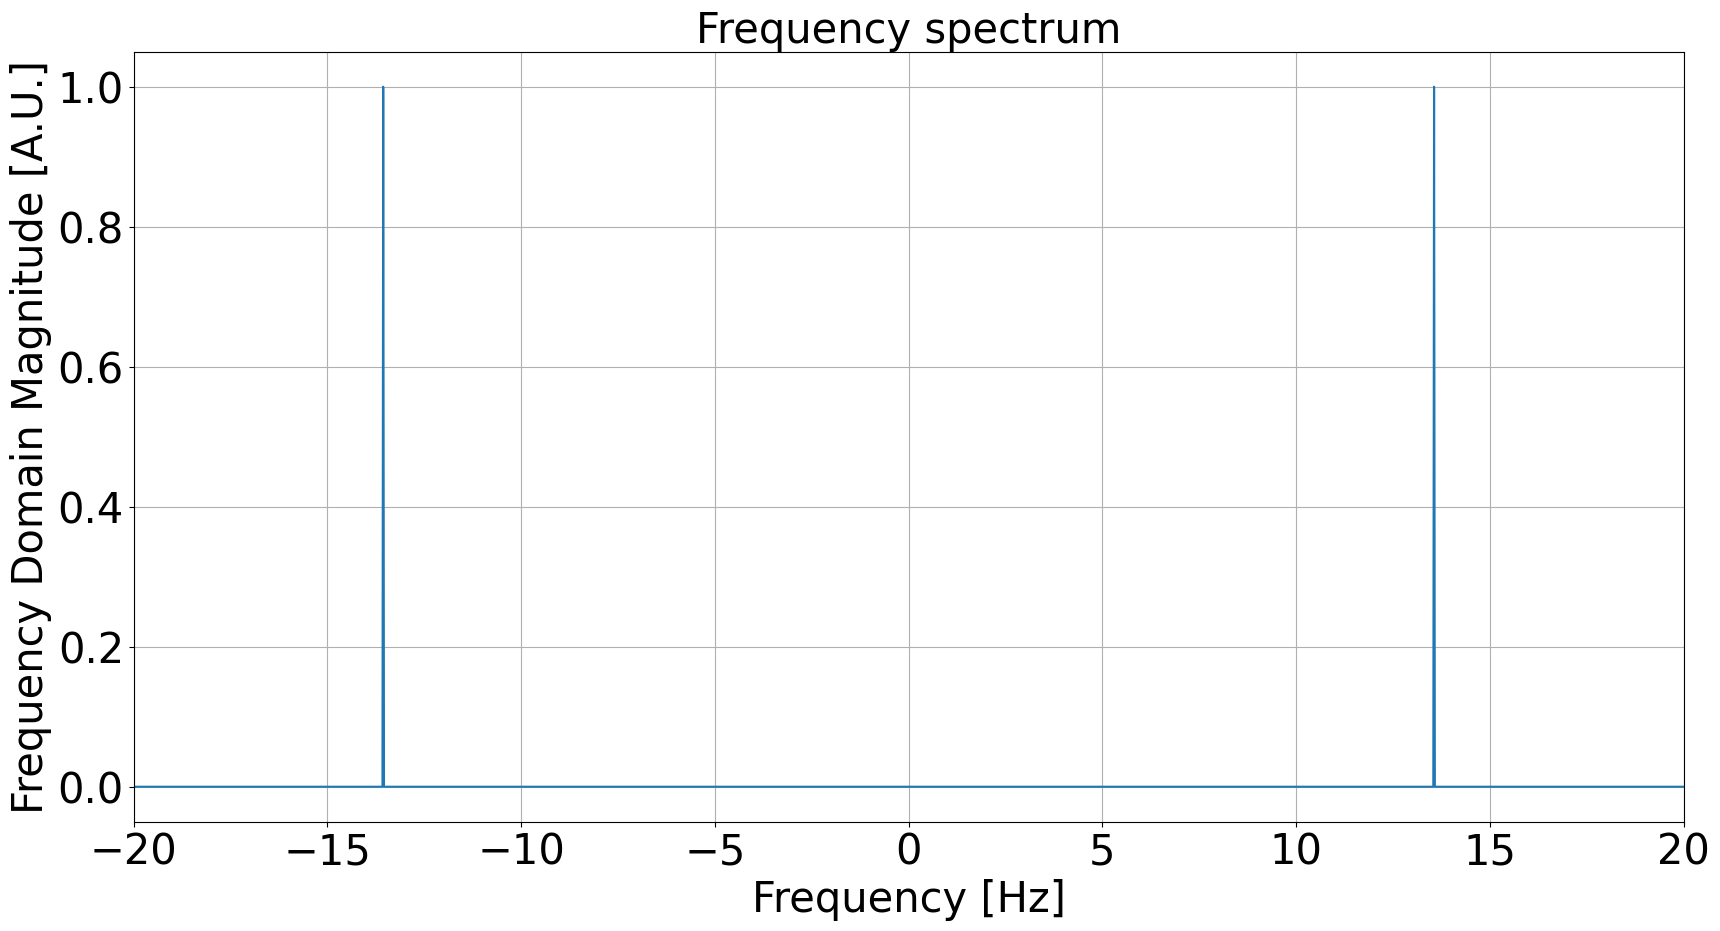

In [14]:
noise_fft_shifted = fft.fftshift(noise_fft)

plt.figure(figsize=(20, 10))
plt.plot(freqs_shifted, np.abs(noise_fft_shifted)/n)

plt.title('Frequency spectrum', fontsize = 30)
plt.xlabel('Frequency [Hz]', fontsize = 30)
plt.xticks(fontsize = 30)
plt.ylabel('Frequency Domain Magnitude [A.U.]', fontsize = 30)
plt.yticks(fontsize = 30)
#plt.xlim(- f_s / 2, f_s / 2) #freq of time sampling
plt.xlim(-20, 20)
plt.grid(True)

#plt.savefig("Results/simple_fft.png", format = "png", bbox_inches="tight")
#plt.savefig("Results/simple_fft.pdf", format = "pdf", bbox_inches="tight")
plt.show()


In [15]:
# times_new_2 = np.arange(N) / f_s_new

#noise_wf = np.sin(peak_f[0]* 2*np.pi * times + peak_phases[0])

noise_wf = fft.ifft(noise_fft)

In [16]:
A = max(noise_wf.real)
f = peak_f[0]
phi = peak_phases[0]
coswave = A*np.cos(f*np.pi*2*times + phi)
sinwave = A*np.sin(f*np.pi*2*times + phi)

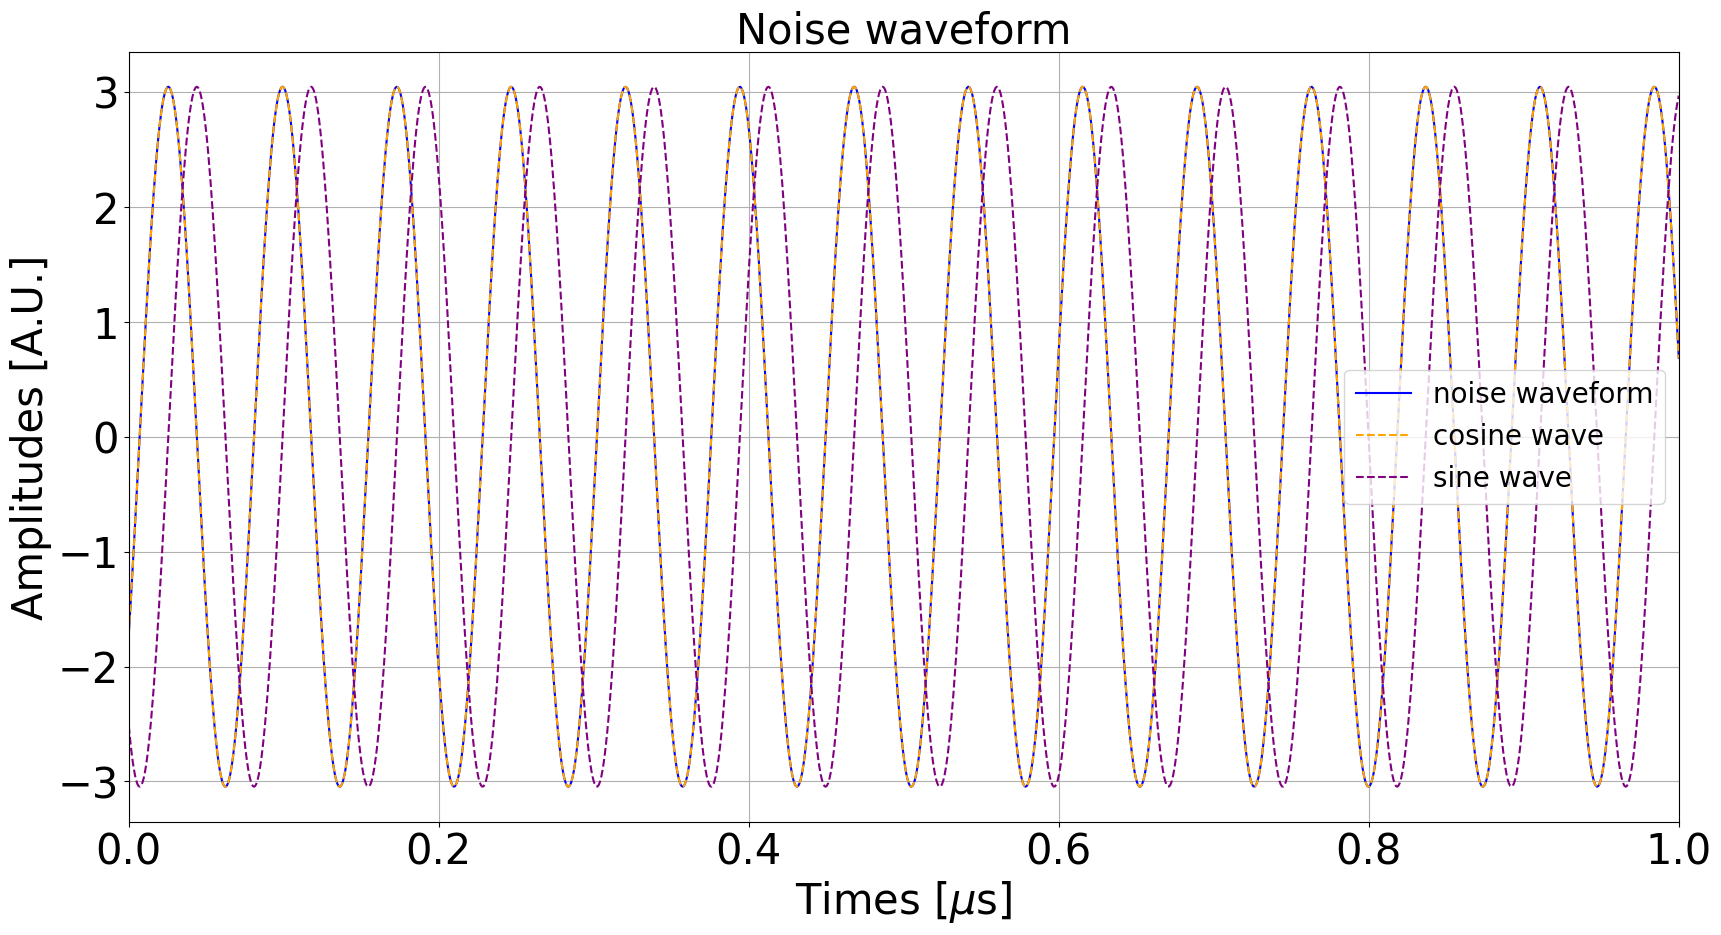

In [17]:
plt.figure(figsize=(20, 10))
#plt.errorbar(freqs, avg_fft_au, yerr = stds_fft, fmt='o', markersize = 2, ecolor='red', capsize = 3, capthick=1, elinewidth=1)
plt.plot(times, noise_wf.real, color = 'blue', label = 'noise waveform') #you can see that it remembers the phase only if you pass the complex numbers as fft to fft.ifft
plt.plot(times, coswave, linestyle = '--', color = 'orange', label = 'cosine wave')
plt.plot(times, sinwave, linestyle = '--', color = 'purple', label = 'sine wave')

plt.title('Noise waveform', fontsize = 30)
plt.xlabel(r'Times [$\mu$s]', fontsize = 30)
plt.xticks(fontsize = 30)
plt.ylabel('Amplitudes [A.U.]', fontsize = 30)
plt.yticks(fontsize = 30)
plt.grid(True)
plt.xlim(0, 1)
plt.legend(loc = 'best', fontsize = 20)

#plt.savefig("250724_17.23/fft.pdf", format = "pdf", bbox_inches="tight")
plt.show()

In [18]:
declareted_phase = peak_phases[0]
print(f"declareted phase: {declareted_phase*180/np.pi}")
real_phase = np.arcsin(noise_wf.real[0]/A)
print(f"real phase: {real_phase*180/np.pi}")
print(f"difference: {(real_phase - declareted_phase)*180/np.pi}")

declareted phase: -124.30009813427507
real phase: -34.300098242630746
difference: 89.99999989164432


## Compare to original waveform

In [19]:
reconstructed_wf = fft.ifft(magnitudes)

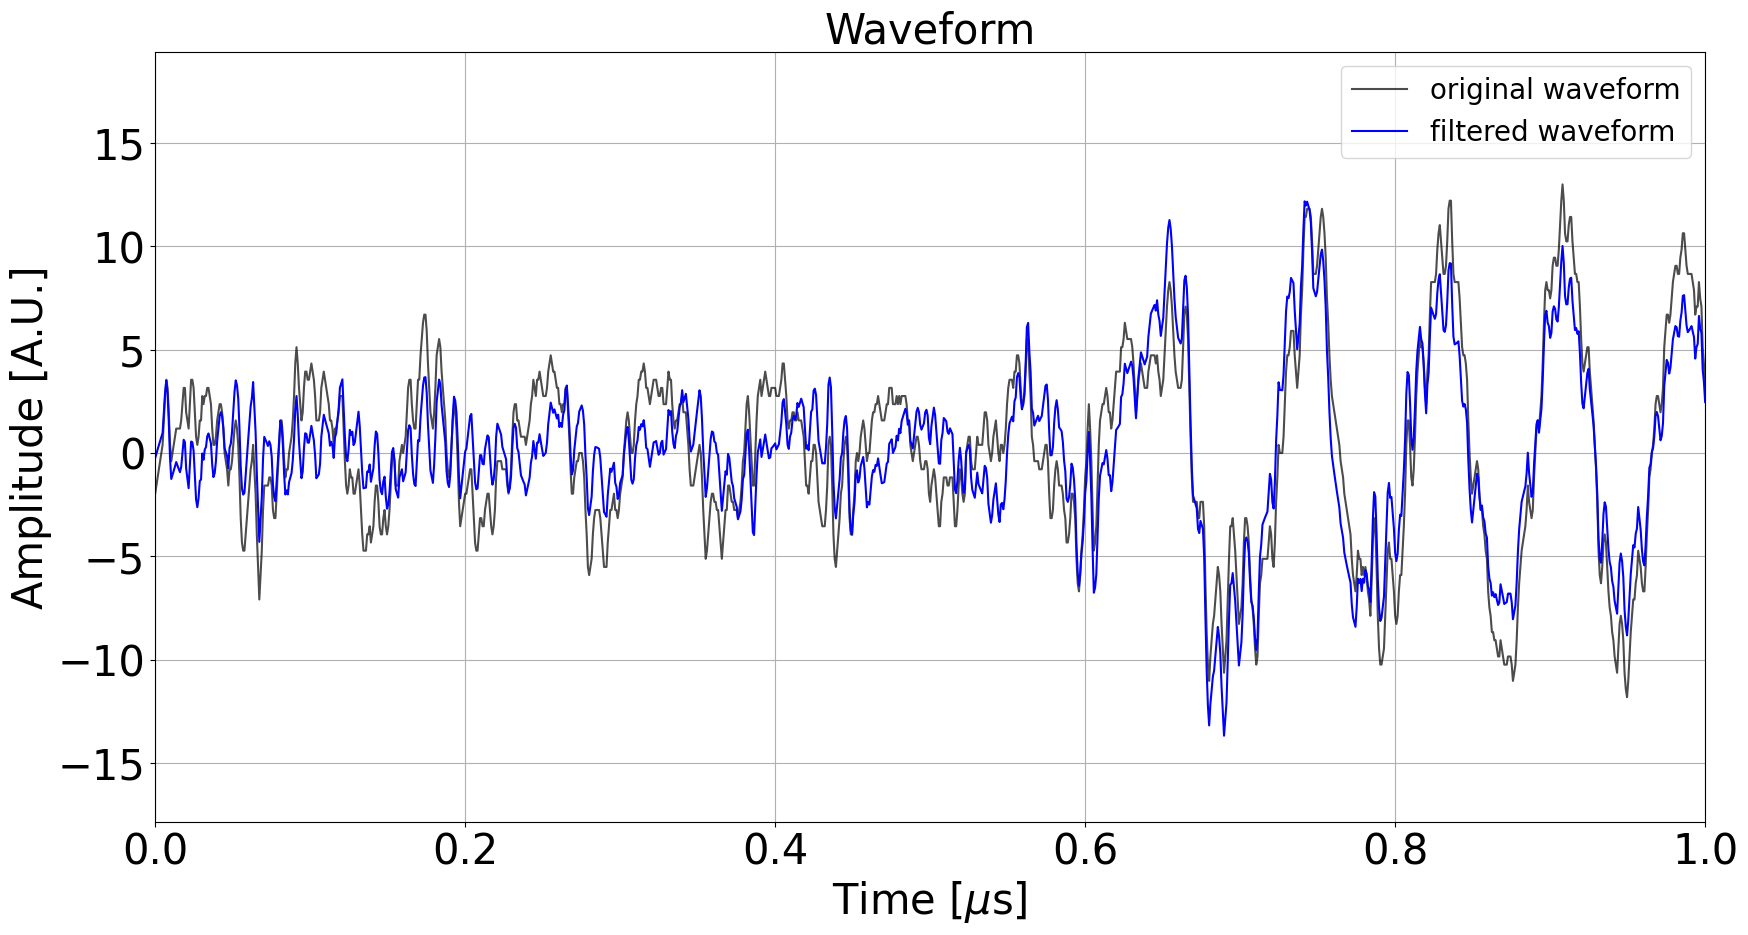

In [20]:
plt.figure(figsize = (20, 10))
plt.plot(times, reconstructed_wf.real, label = 'original waveform', color = 'black', alpha = 0.7)
plt.plot(times, reconstructed_wf.real - noise_wf.real, label = 'filtered waveform', color = 'blue')
plt.title('Waveform', fontsize = 30)
plt.xlabel(r'Time [$\mu$s]', fontsize = 30)
plt.xticks(fontsize = 30)
plt.ylabel('Amplitude [A.U.]', fontsize = 30)
plt.yticks(fontsize = 30)
plt.grid(True)
plt.xlim(0, 1)
plt.legend(loc = 'best', fontsize = 20)

#plt.savefig("Results/simple_ifft.png", format = "png", bbox_inches="tight")
#plt.savefig("Results/simple_ifft.pdf", format = "pdf", bbox_inches="tight")
plt.show()

# Make sure reconstructed waveform and original waveform are the same

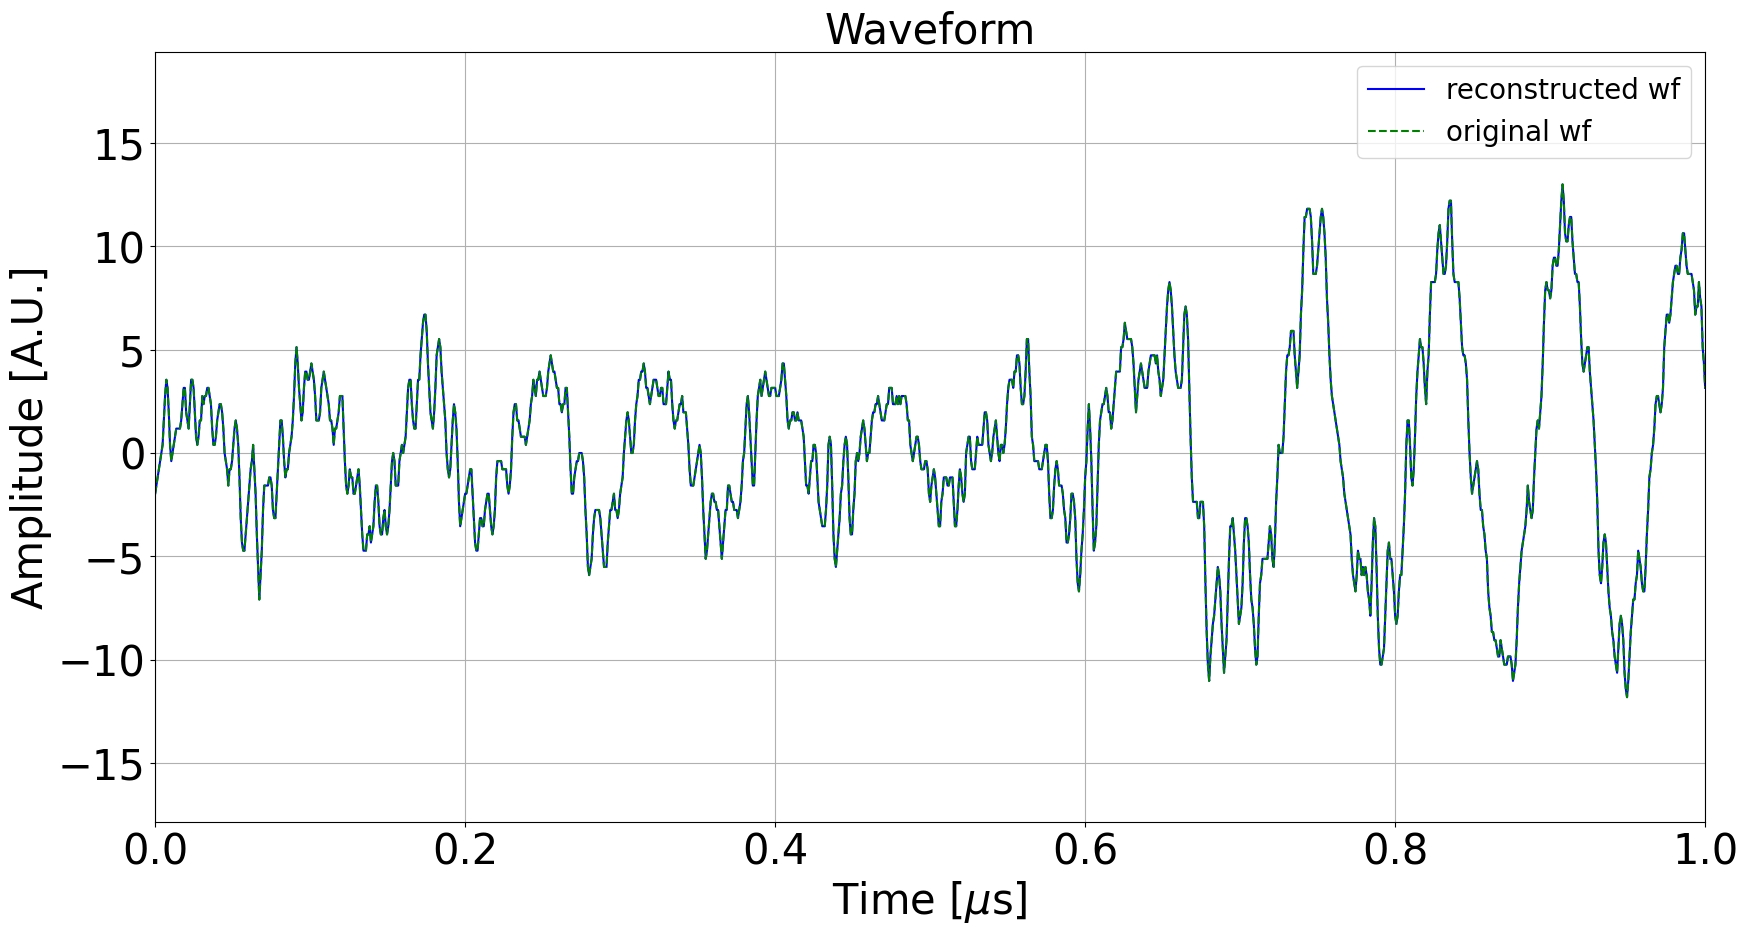

In [21]:
plt.figure(figsize = (20, 10))
plt.plot(times, reconstructed_wf.real, label = 'reconstructed wf', color = 'blue') #why real?
plt.plot(times, amplitudes, label = 'original wf', color = 'green', linestyle = '--')

plt.title('Waveform', fontsize = 30)
plt.xlabel(r'Time [$\mu$s]', fontsize = 30)
plt.xticks(fontsize = 30)
plt.ylabel('Amplitude [A.U.]', fontsize = 30)
plt.yticks(fontsize = 30)
plt.grid(True)
plt.xlim(0, 1)
plt.legend(loc = 'best', fontsize = 20)

#plt.savefig("Results/simple_ifft.png", format = "png", bbox_inches="tight")
#plt.savefig("Results/simple_ifft.pdf", format = "pdf", bbox_inches="tight")
plt.show()

In [22]:
reconstructed_filtered_wf = reconstructed_wf -noise_wf
reconstructed_filtered_fft = fft.fft(reconstructed_filtered_wf)

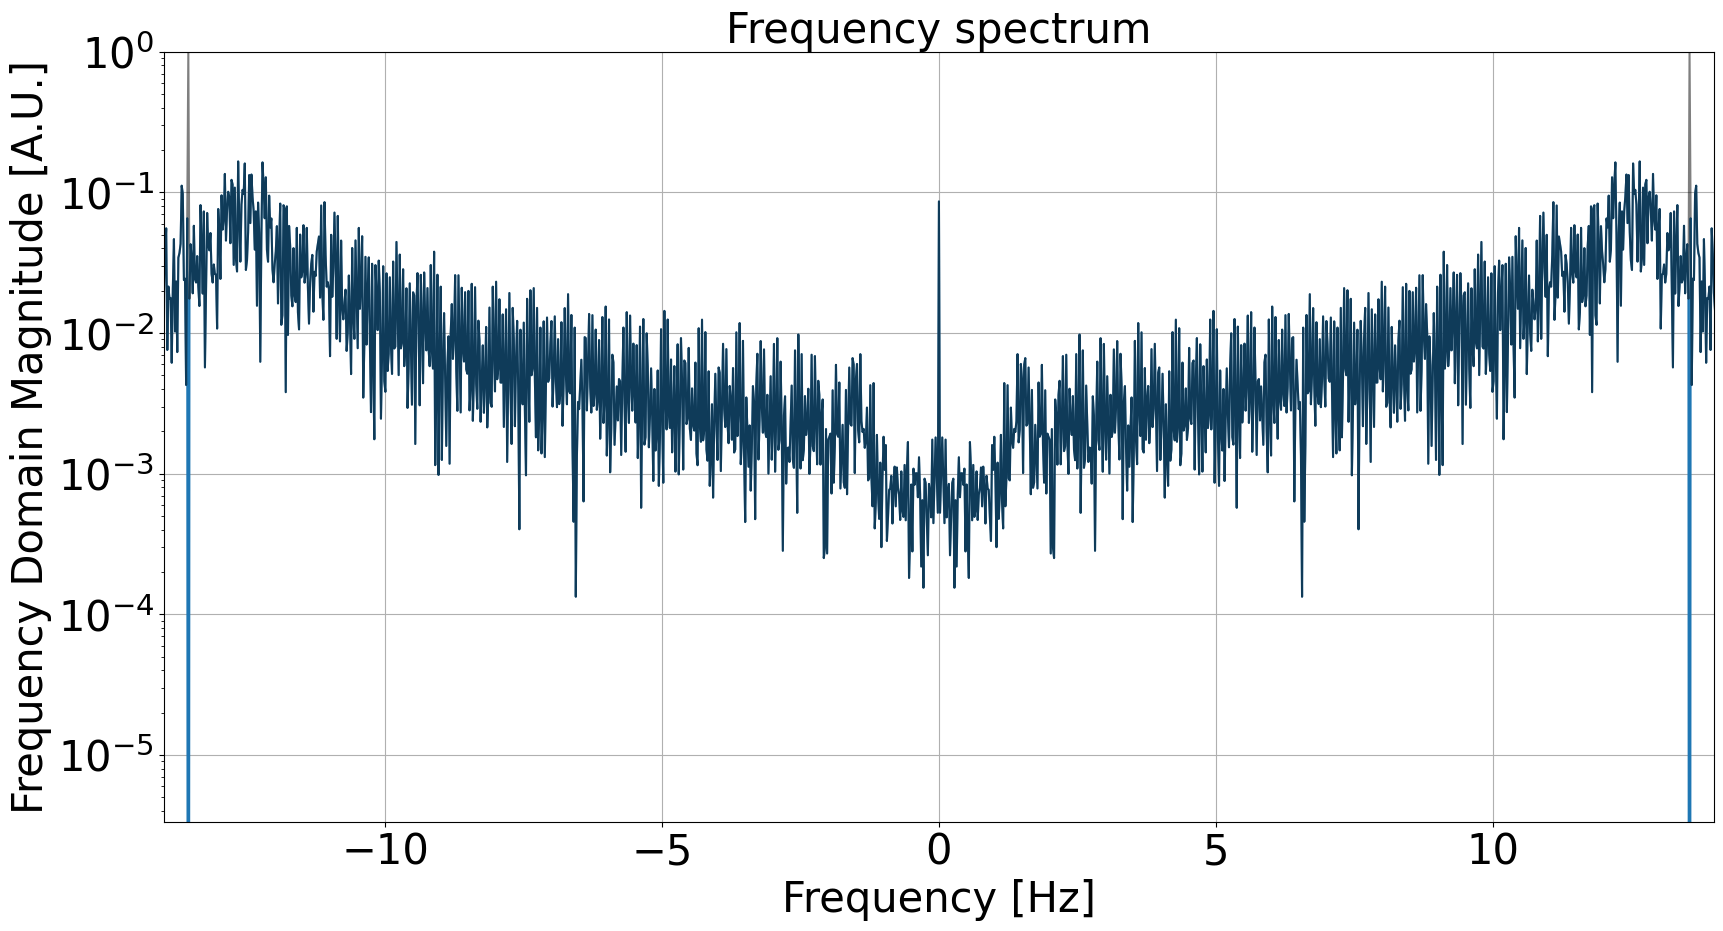

In [51]:
reconstructed_filtered_fft_shifted = fft.fftshift(reconstructed_filtered_fft)

plt.figure(figsize=(20, 10))
plt.plot(freqs_shifted, np.abs(reconstructed_filtered_fft_shifted)/n)
plt.plot(freqs_shifted, np.abs(magnitudes_shifted)/n, color = 'k', alpha = 0.5)

plt.title('Frequency spectrum', fontsize = 30)
plt.xlabel('Frequency [Hz]', fontsize = 30)
plt.xticks(fontsize = 30)
plt.ylabel('Frequency Domain Magnitude [A.U.]', fontsize = 30)
plt.yticks(fontsize = 30)
#plt.xlim(- f_s / 2, f_s / 2) #freq of time sampling
plt.semilogy()
plt.ylim([min(np.abs(magnitudes_shifted)/n), max(np.abs(magnitudes_shifted)/n)])  # Adjust the y-axis range
plt.xlim(-f2, f2)
plt.grid(True)

#plt.savefig("Results/simple_fft.png", format = "png", bbox_inches="tight")
#plt.savefig("Results/simple_fft.pdf", format = "pdf", bbox_inches="tight")
plt.show()